In [1]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import wordcloud
from io import StringIO
import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_colwidth', 255)

In [3]:
subjects = []
for media in ['France 3', 'France 2', 'TF1']:
    for year in ['2022']:
        for month in ['11']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [4]:
data = pd.DataFrame(subjects)

In [53]:
focus_media = "tf1"
edition = "20h"
days_ago = 1

In [54]:
today = datetime.date.today()
start_delta = datetime.timedelta(days=days_ago)

In [55]:
start = today - start_delta

In [66]:
end = start + datetime.timedelta(days=2)

In [67]:
start, end

(datetime.date(2022, 11, 6), datetime.date(2022, 11, 8))

In [68]:
focus_day = data[(data.media == focus_media)
                 & (data["date"] >= start.strftime("%Y-%m-%d")) 
                 & (data["date"] < end.strftime("%Y-%m-%d")) ].copy()

In [69]:
import re
if focus_media == 'tf1':
    topic_pattern = re.compile("https://www.tf1info.fr/(\S+)/(\S+).html")
    focus_day['topic'] = [topic_pattern.match(u).group(1) for u in focus_day.url]
    
if focus_media == 'france2':
    topic_pattern = re.compile("https://www.francetvinfo.fr/(\S+)/(\S+).html")
    focus_day['topic'] = [topic_pattern.match(u).group(1).split('/')[0] 
                              for u in [x.replace('https://www.francetvinfo.frhttps://www.francetvinfo.fr', 'https://www.francetvinfo.fr') for x in focus_day.url]]

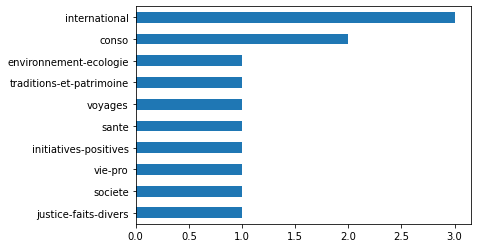

In [70]:
focus_day['topic'].value_counts().plot(kind='barh').invert_yaxis()

In [71]:
if focus_media == 'france2':
    focus_day['formatted_date'] = [d.strftime('%d %B, %A') for d in pd.to_datetime(focus_day.date)]  
if focus_media == 'tf1':
    focus_day['formatted_date'] = [(d - datetime.timedelta(hours=20)+datetime.timedelta(minutes=1)).strftime('%d %B, %A') for d in pd.to_datetime(focus_day.date)]

<AxesSubplot:>

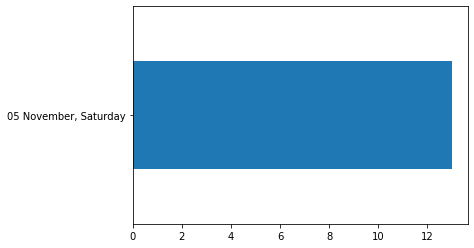

In [72]:
focus_day['formatted_date'].value_counts().plot(kind='barh')

In [62]:
if focus_media == 'france2' and edition == "20h":
    focus_edition = focus_day[['20h' in x for x in focus_day.urlTvNews]].copy()
if focus_media == 'france2' and edition == "13h":
    focus_edition = focus_day[['13h' in x for x in focus_day.urlTvNews]].copy()
if focus_media == 'tf1' and edition == "20h":
    focus_edition = focus_day[[('20h' in x) or ('we' in x and d[11:13] >= "20") for x,d in zip(focus_day.urlTvNews, focus_day.date)]].copy()

In [63]:
focus_edition

,title,description,date,order,presenter,authors,editor,editorDeputy,url,urlTvNews,containsWordGlobalWarming,media,topic,formatted_date


In [40]:
if focus_media == 'tf1':
    focus_edition['id'] = [x.split('-')[-1][:-5] for x in focus_edition.url]
    focus_edition['order'] = focus_edition['date']
    if focus_edition.formatted_date.nunique() == 1:
        order_by_id = focus_edition.set_index('id').order.rank(method='first').reset_index().set_index('id').order 
    else:
        order_by_id = focus_edition.groupby('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    focus_edition['order'] = [focus_edition[x] for x in focus_edition.id]

KeyError: '2237732'

In [41]:
if False:
    last_week_edition = last_week[['we' in x for x in last_week.urlTvNews]].copy()
    last_week_edition['id'] = [x.split('-')[-1][:-5] for x in last_week_edition.url]
    last_week_edition['order'] = last_week_20h['id']
    order_by_id = last_week_edition.last_week_edition('formatted_date').apply(lambda x: x.set_index('id').order.rank(method='first')).reset_index().set_index('id').order    
    last_week_edition['order'] = [order_by_id[x] for x in last_week_edition.id]

In [153]:
conducteur = last_week_edition.pivot(index='order', columns='formatted_date', values='title')

In [154]:
last_week_edition.formatted_date.value_counts().sort_index()

31 October, Monday    8
Name: formatted_date, dtype: int64

In [155]:
conducteur

formatted_date,"31 October, Monday"
order,
1.0,Flambée des prix de l'énergie : ces entreprises qui s'arrêtent
2.0,Les résidences secondaires bientôt surtaxées ?
3.0,Deux-roues : bientôt un contrôle technique
4.0,"Sainte-Soline : qui sont les ""écoterroristes"" ?"
5.0,Tornade dans le Pas-de-Calais : comment reconstruire le champ de ruines ?
6.0,Bombardements russes : coupures d'électricité et d'eau en Ukraine
7.0,Dans le spectaculaire parc de Grand Teton
8.0,"VIDÉO - Brésil : après l'élection présidentielle, le pays plus divisé que jamais"


In [156]:
query  = "climat"
last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())][['date', 'media', 'title', 'url']]

,date,media,title,url


In [157]:
print(last_week_edition[last_week_edition.description.apply(lambda x : query in x.lower())]['description'].iloc[0])

IndexError: single positional indexer is out-of-bounds